In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from abbyy_course_cvdl_t3.coco_text import COCO_Text

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base = Path("/home/avashchilko/coco2014")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [3]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.958559
creating index...
index created!


### Подготовка датасетов


In [4]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation


In [6]:
cd ../task2

/home/avashchilko/abbyy9sem/course_cvdl/task2


In [7]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform


In [8]:
cd ../task3

/home/avashchilko/abbyy9sem/course_cvdl/task3


In [9]:
ds_train = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640))
)

In [10]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640)),
    split='val'
)

In [11]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [12]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

### Оценка качества модели

In [13]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [24]:
model = torch.load('retina_coco_text.pth')
model.to(torch.device('cuda:0'));
model.eval();

Text(0.5, 1.0, 'GT: 101243')

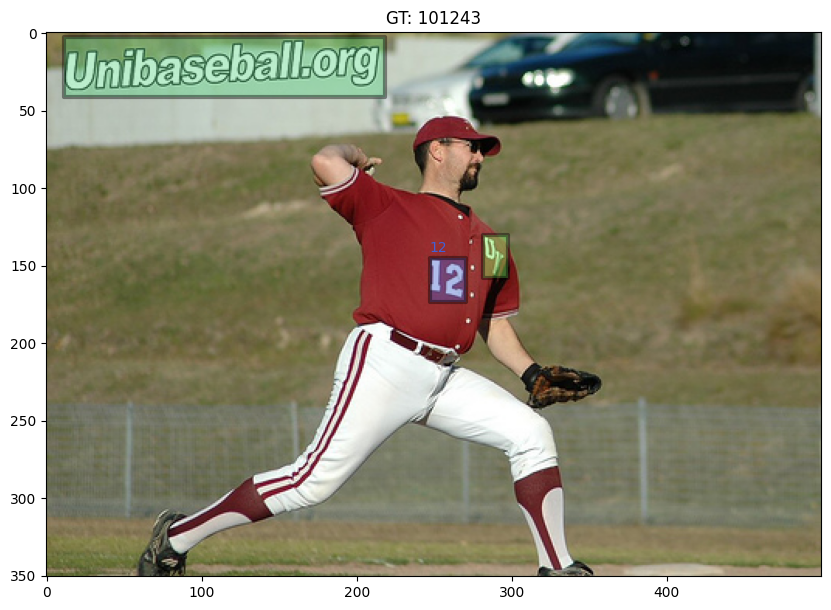

In [25]:
img_id = 101243
img_meta = ct.loadImgs(ids=[img_id])[0]
plt.imshow(plt.imread(images_path / img_meta['file_name']))
annIds = ct.getAnnIds(imgIds=img_meta['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title(f"GT: {img_meta['id']}")


In [26]:
img, anno = ds_val[ds_val.ids.index(str(img_id))]

In [31]:
preds = model(torch.Tensor(img)[None, ...].to('cuda:0'))[0]

In [32]:
import torchvision

Text(0.5, 1.0, 'Pred: все боксы')

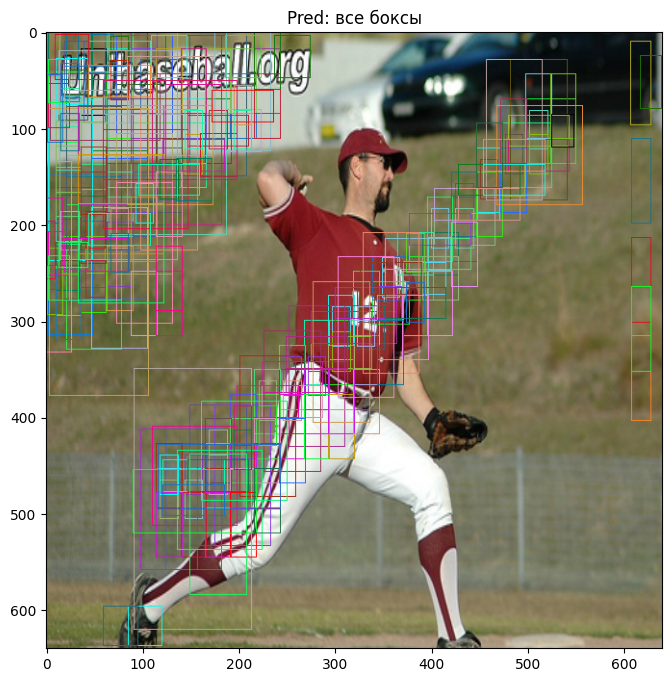

In [33]:
plt.imshow(
    torchvision.utils.draw_bounding_boxes(
        (img * 255 ).type(torch.uint8), 
        preds['boxes'],
    ).permute(1, 2, 0),
)
plt.title("Pred: все боксы")

Text(0.5, 1.0, 'Pred: боксы с score > 0.35')

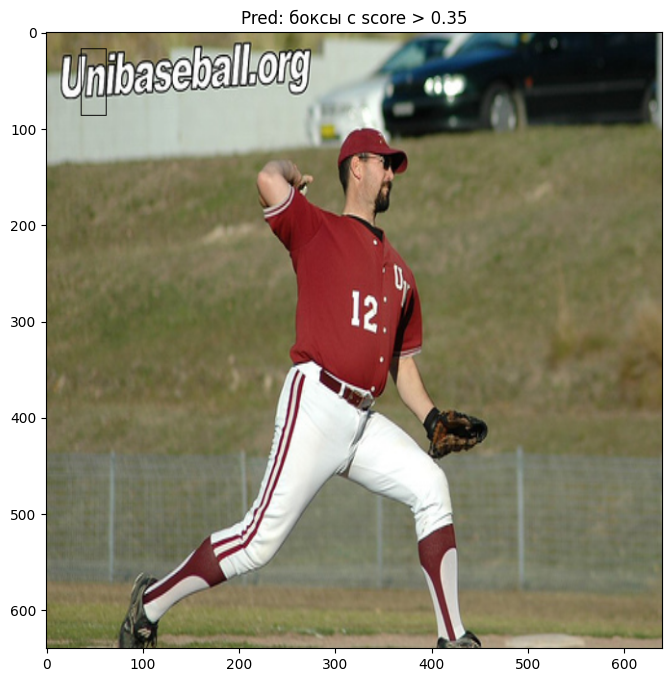

In [34]:
high_confidence_scores = preds['scores'] > 0.25
high_confidence_boxes = preds['boxes'][high_confidence_scores]
plt.imshow(
    torchvision.utils.draw_bounding_boxes(
        (img * 255 ).type(torch.uint8), 
        high_confidence_boxes
    ).permute(1, 2, 0),
)
plt.title("Pred: боксы с score > 0.35")

Стандартные детекторы плохо справляются с детектированием боксов aspect_ratio >> 1, поэтому есть много специализированных моделей для детекции текста.

HINT: в retina по умолчанию отключен NMS, но его можно включить

### Подготовка файла предсказаний

In [42]:
def postprocess(preds, size_src=None, size_current=None):
    """
    Перевод предсказаний Retina в формате [xmin, ymin, xmax, ymax], 
    в формат COCO [xmin, ymin, wx, hy]
    Масштабирование боксов согласно оригинальному размеру изображения.
    """
    unfold_results = {}
    unf = {"scores": preds["scores"].cpu().detach().numpy()}
    b = preds["boxes"].clone().detach()
    boxes = b.clone()
        
    boxes[:, 2] = (b[:, 2] - b[:, 0])
    boxes[:, 3] = (b[:, 3] - b[:, 1])
    if size_src is not None and size_current is not None:
        mult_0 = size_src[0] / size_current[0]
        mult_1 = size_src[1] / size_current[1]

        boxes[:, 0] *= mult_0
        boxes[:, 2] *= mult_0
        boxes[:, 1] *= mult_1
        boxes[:, 3] *= mult_1
    unf['boxes'] = boxes.cpu().numpy()
        
    return unf

### Посчитаем предсказания на val датасете

In [43]:
prepared_preds = []
img_ids = []

for num, img_id in enumerate(tqdm(ds_val.ids)):
    img_id = int(img_id)
    img_meta = ct.loadImgs(ids=[img_id])[0]
    with torch.no_grad():
        x = ds_val[num][0]
        pred = model([
            x.to('cuda:0')
        ])[0]
        prepared_preds.append(
            postprocess(
                pred,
                size_src=[img_meta['width'], img_meta['height']], 
                size_current=[640, 640]
            )
        )
        img_ids.append(img_id)


100%|████████████████████████████████████████████████████████████████████| 4446/4446 [02:28<00:00, 29.89it/s]


### Эта функция соранит детекции в нужном формате

In [45]:
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [46]:
scores = np.concatenate([u['scores'] for u in prepared_preds])
boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)

In [47]:
scores

array([0.09375181, 0.09086905, 0.08870613, ..., 0.05115007, 0.05078785,
       0.05057532], dtype=float32)

In [48]:
boxes

array([[579.60614 , 125.83578 ,  25.553467,  59.002174],
       [396.04294 , 150.67459 ,  26.805115,  45.35763 ],
       [293.6429  , 185.31459 ,  26.805145,  45.357643],
       ...,
       [144.23805 , 181.51984 ,  18.549957,  31.5081  ],
       [195.43805 , 161.71983 ,  18.549942,  31.5081  ],
       [613.1607  ,   8.287524,  19.463562,  23.60598 ]], dtype=float32)

In [49]:
image_ids = []
for num, i in enumerate(img_ids):
    image_ids += [i] * len(prepared_preds[num]['boxes'])
image_ids = np.array(image_ids)

In [50]:
dump_detections_to_cocotext_json(
    image_ids = image_ids.tolist(),
    xlefts=boxes[:, 0].tolist(),
    ytops=boxes[:, 1].tolist(),
    widths=boxes[:, 2].tolist(),
    heights=boxes[:, 3].tolist(),
    scores=scores.tolist(),
    path='predictions.json'
);
    

### Эта функция посчитает AP детекций
AP считается согласно PASCAL-VOC - площадь под Precision-Recall кривой.

Дополнительно из Ground Truth выбрасываются объекты с площадью меньше 1/32/32, т.к. для уверенного детектирования таких объектов придется тренировать детектора в большом разрешении.
По умолчанию во время тренировки CocoTextDetection также выбрасывает такие боксы, определяется параметром area_fraction_threshold.

In [51]:
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json

In [52]:
ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path='predictions.json'
)
print(f"Итоговый скор AP на val: {ap}")

Loading and preparing results...     
DONE (t=30.83s)
Итоговый скор AP на val: 0.002406246124086399


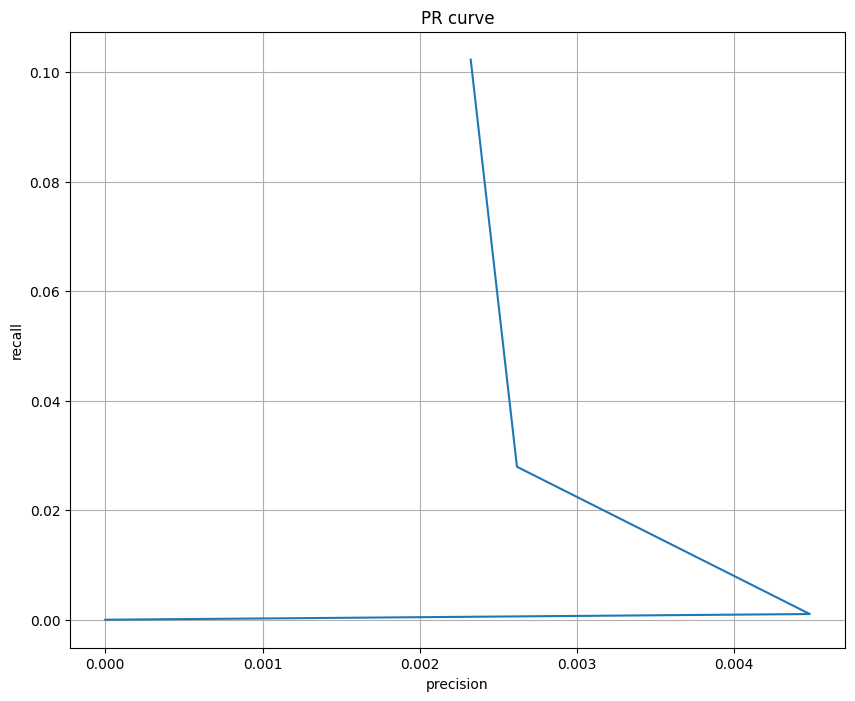

In [53]:
from matplotlib import pyplot as plt
plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()